# Airbnb NYC Rental Prices Analysis

**Author:** David Graham

**Dataset:** Airbnb NYC 2019 Listings

## Project Description

This project performs an exploratory data analysis on the Airbnb NYC 2019 dataset to uncover patterns and relationships between listing features and rental prices. Through data visualization and statistical analysis, we aim to identify key factors that influence pricing and discover meaningful insights about the short-term rental market in New York City.

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load Dataset

In [2]:
df = pd.read_csv("AB_NYC_2019.csv")
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


## Data Cleaning Functions

In [3]:
def handle_missing_values(dataframe, numeric_strategy='median', text_strategy='Unknown'):
    """
    Handle missing values in a DataFrame by filling numeric columns with a 
    specified strategy and text columns with a placeholder value.
    
    Parameters:
    -----------
    dataframe : pd.DataFrame
        The input DataFrame with missing values
    numeric_strategy : str, default='median'
        Strategy for filling numeric columns ('median', 'mean', or 'zero')
    text_strategy : str, default='Unknown'
        Value to fill missing text/object columns
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with missing values handled
    """
    df_clean = dataframe.copy()
    
    for column in df_clean.columns:
        if df_clean[column].isnull().sum() > 0:
            if df_clean[column].dtype in ['float64', 'int64']:
                if numeric_strategy == 'median':
                    df_clean[column] = df_clean[column].fillna(df_clean[column].median())
                elif numeric_strategy == 'mean':
                    df_clean[column] = df_clean[column].fillna(df_clean[column].mean())
                else:
                    df_clean[column] = df_clean[column].fillna(0)
            else:
                df_clean[column] = df_clean[column].fillna(text_strategy)
    
    return df_clean


def remove_price_outliers(dataframe, price_column='price', lower_percentile=1, upper_percentile=99):
    """
    Remove outliers from the price column based on percentile thresholds.
    This helps eliminate extreme values that could skew analysis results.
    
    Parameters:
    -----------
    dataframe : pd.DataFrame
        The input DataFrame containing price data
    price_column : str, default='price'
        Name of the column containing price values
    lower_percentile : int, default=1
        Lower percentile threshold (removes values below this)
    upper_percentile : int, default=99
        Upper percentile threshold (removes values above this)
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with price outliers removed
    """
    df_clean = dataframe.copy()
    
    lower_bound = df_clean[price_column].quantile(lower_percentile / 100)
    upper_bound = df_clean[price_column].quantile(upper_percentile / 100)
    
    original_count = len(df_clean)
    df_clean = df_clean[(df_clean[price_column] >= lower_bound) & 
                        (df_clean[price_column] <= upper_bound)]
    
    removed_count = original_count - len(df_clean)
    print(f"Removed {removed_count} outliers ({removed_count/original_count*100:.2f}%)")
    print(f"Price range: ${lower_bound:.0f} - ${upper_bound:.0f}")
    
    return df_clean

## Apply Cleaning Functions

In [4]:
# Check missing values before cleaning
print("Missing values before cleaning:")
print(df.isnull().sum())
print(f"\nTotal rows: {len(df)}")

Missing values before cleaning:
id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Total rows: 48895


In [5]:
# Apply cleaning functions
df_clean = handle_missing_values(df)
df_clean = remove_price_outliers(df_clean)

# Verify cleaning results
print("\nMissing values after cleaning:")
print(df_clean.isnull().sum())
print(f"\nFinal row count: {len(df_clean)}")

Removed 878 outliers (1.80%)
Price range: $30 - $799

Missing values after cleaning:
id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

Final row count: 48017


### Cleaning Justification

The data cleaning steps above address two critical issues in the raw dataset:

**Missing Value Handling:** The original dataset contains missing values in several columns, including `name`, `host_name`, `last_review`, and `reviews_per_month`. Missing numeric values (like `reviews_per_month`) were filled with the median to preserve the central tendency of the distribution without being influenced by outliers. Missing text values were filled with "Unknown" to maintain data integrity while clearly marking incomplete records. This approach ensures all rows can be included in subsequent analysis without introducing NaN-related errors.

**Outlier Removal:** The price column contained extreme values that would distort summary statistics and visualizations. Some listings showed prices of $0 (likely errors or placeholder values) while others exceeded $10,000 per night (potentially luxury properties or data entry errors). By removing the bottom 1% and top 1% of prices, we focus the analysis on typical listings while acknowledging that this may exclude legitimate edge cases. This trade-off improves the reliability of aggregate statistics like mean and standard deviation.

## Exploratory Data Analysis Functions

In [6]:
def get_summary_statistics(dataframe, numeric_only=True):
    """
    Generate comprehensive summary statistics for a DataFrame including
    count, mean, std, min, max, and percentiles for numeric columns.
    
    Parameters:
    -----------
    dataframe : pd.DataFrame
        The input DataFrame to analyze
    numeric_only : bool, default=True
        If True, only include numeric columns in the summary
    
    Returns:
    --------
    pd.DataFrame
        Summary statistics including additional metrics like skewness
    """
    if numeric_only:
        numeric_df = dataframe.select_dtypes(include=[np.number])
    else:
        numeric_df = dataframe
    
    summary = numeric_df.describe()
    
    # Add additional statistics
    summary.loc['skew'] = numeric_df.skew()
    summary.loc['median'] = numeric_df.median()
    
    return summary.round(2)


def analyze_by_group(dataframe, group_column, value_column, agg_funcs=['mean', 'median', 'count']):
    """
    Perform grouped analysis on a DataFrame, calculating aggregate statistics
    for a value column grouped by a categorical column.
    
    Parameters:
    -----------
    dataframe : pd.DataFrame
        The input DataFrame to analyze
    group_column : str
        Column name to group by (categorical)
    value_column : str
        Column name to calculate statistics for (numeric)
    agg_funcs : list, default=['mean', 'median', 'count']
        List of aggregation functions to apply
    
    Returns:
    --------
    pd.DataFrame
        Grouped statistics sorted by mean value descending
    """
    grouped = dataframe.groupby(group_column)[value_column].agg(agg_funcs)
    grouped = grouped.sort_values(by='mean', ascending=False)
    
    return grouped.round(2)


def get_correlation_analysis(dataframe, target_column=None, threshold=0.3):
    """
    Calculate correlation matrix for numeric columns and optionally
    highlight correlations with a target column above a threshold.
    
    Parameters:
    -----------
    dataframe : pd.DataFrame
        The input DataFrame to analyze
    target_column : str, optional
        If provided, show correlations with this column sorted by strength
    threshold : float, default=0.3
        Minimum absolute correlation value to highlight
    
    Returns:
    --------
    pd.DataFrame or pd.Series
        Full correlation matrix, or correlations with target column
    """
    numeric_df = dataframe.select_dtypes(include=[np.number])
    correlation_matrix = numeric_df.corr()
    
    if target_column and target_column in correlation_matrix.columns:
        target_corr = correlation_matrix[target_column].drop(target_column)
        target_corr = target_corr.sort_values(key=abs, ascending=False)
        
        print(f"Correlations with '{target_column}' (|r| >= {threshold}):")
        significant = target_corr[abs(target_corr) >= threshold]
        return significant.round(3)
    
    return correlation_matrix.round(3)

## Run Exploratory Analysis

In [7]:
# Summary Statistics
print("=== Summary Statistics ===\n")
get_summary_statistics(df_clean)

=== Summary Statistics ===



,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48017.00,4.801700e+04,48017.00,48017.00,48017.00,48017.00,48017.00,48017.00,48017.00,48017.00
mean,18976512.73,6.729578e+07,40.73,-73.95,138.50,6.97,23.47,1.24,7.20,112.07
std,10980074.04,7.846406e+07,0.05,0.05,103.69,20.30,44.78,1.53,33.21,131.22
min,2539.00,2.438000e+03,40.50,-74.24,30.00,1.00,0.00,0.01,1.00,0.00
25%,9437085.00,7.755859e+06,40.69,-73.98,70.00,1.00,1.00,0.27,1.00,0.00
50%,19621042.00,3.053256e+07,40.72,-73.96,105.00,3.00,5.00,0.72,1.00,44.00
75%,29096185.00,1.074178e+08,40.76,-73.94,175.00,5.00,24.00,1.60,2.00,224.00
max,36487245.00,2.743213e+08,40.91,-73.71,799.00,1250.00,629.00,58.50,327.00,365.00
skew,-0.09,1.220000e+00,0.24,1.30,2.28,22.47,3.67,3.60,7.88,0.77
median,19621042.00,3.053256e+07,40.72,-73.96,105.00,3.00,5.00,0.72,1.00,44.00


In [8]:
# Grouped Analysis: Price by Neighbourhood Group
print("=== Price by Borough ===\n")
analyze_by_group(df_clean, 'neighbourhood_group', 'price')

=== Price by Borough ===



,mean,median,count
neighbourhood_group,,,
Manhattan,173.23,149.0,21266
Brooklyn,116.85,91.0,19791
Staten Island,96.00,75.0,360
Queens,95.13,75.0,5568
Bronx,86.96,69.0,1032


In [9]:
# Grouped Analysis: Price by Room Type
print("=== Price by Room Type ===\n")
analyze_by_group(df_clean, 'room_type', 'price')

=== Price by Room Type ===



,mean,median,count
room_type,,,
Entire home/apt,189.26,160.0,24999
Private room,83.91,70.0,22042
Shared room,71.34,51.5,976


In [10]:
# Correlation Analysis
print("=== Correlation Analysis ===\n")
get_correlation_analysis(df_clean, target_column='price', threshold=0.1)

=== Correlation Analysis ===

Correlations with 'price' (|r| >= 0.1):


longitude                        -0.272
calculated_host_listings_count    0.151
availability_365                  0.115
Name: price, dtype: float64

## Visualizations

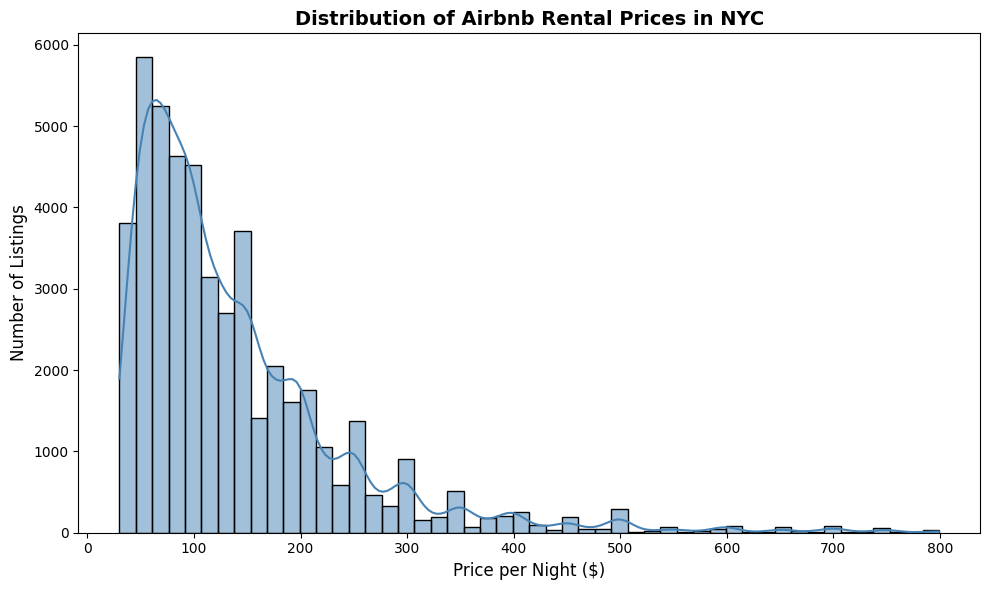

In [11]:
# Visualization 1: Distribution of Rental Prices
plt.figure(figsize=(10, 6))
sns.histplot(data=df_clean, x='price', bins=50, kde=True, color='steelblue')
plt.title('Distribution of Airbnb Rental Prices in NYC', fontsize=14, fontweight='bold')
plt.xlabel('Price per Night ($)', fontsize=12)
plt.ylabel('Number of Listings', fontsize=12)
plt.tight_layout()
plt.show()

**Interpretation:** The histogram reveals a strongly right-skewed distribution of rental prices. The majority of NYC Airbnb listings are priced between $50 and $150 per night, with the peak frequency occurring around $50-75. The long tail extending toward higher prices indicates that while most listings are affordable, a smaller number of premium properties command significantly higher rates. The kernel density estimate (KDE) curve confirms this pattern, showing a sharp rise at lower prices followed by a gradual decline.

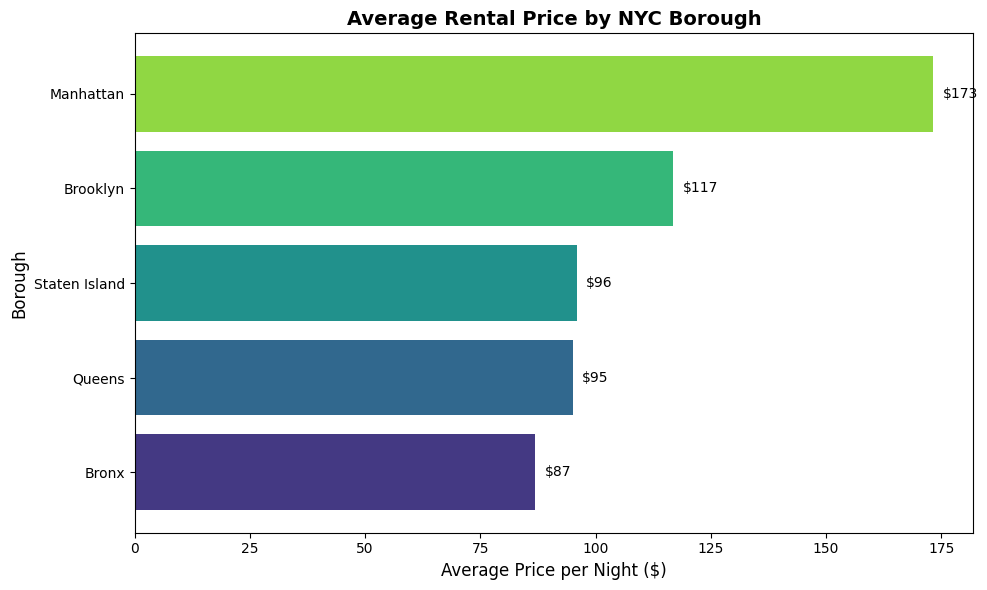

In [12]:
# Visualization 2: Average Price by Borough
plt.figure(figsize=(10, 6))
borough_prices = df_clean.groupby('neighbourhood_group')['price'].mean().sort_values(ascending=True)
colors = sns.color_palette('viridis', len(borough_prices))
bars = plt.barh(borough_prices.index, borough_prices.values, color=colors)
plt.title('Average Rental Price by NYC Borough', fontsize=14, fontweight='bold')
plt.xlabel('Average Price per Night ($)', fontsize=12)
plt.ylabel('Borough', fontsize=12)

# Add value labels on bars
for bar, value in zip(bars, borough_prices.values):
    plt.text(value + 2, bar.get_y() + bar.get_height()/2, f'${value:.0f}', 
             va='center', fontsize=10)

plt.tight_layout()
plt.show()

**Interpretation:** The horizontal bar chart clearly shows geographic price variation across NYC boroughs. Manhattan has the highest average price per night, followed by Brooklyn, Queens, the Bronx, and Staten Island. This ranking reflects real estate values and tourist demand in each area. Manhattan's premium pricing aligns with its concentration of attractions, business districts, and transportation access. The price gap between Manhattan and the outer boroughs is substantial, suggesting that location is a primary driver of Airbnb pricing in NYC.

**Interpretation:** The box plot demonstrates a clear price hierarchy by room type. Entire home/apartment listings show the highest median price and widest interquartile range, indicating both higher typical prices and greater price variability. Private rooms cluster at a moderate price point with less variation, while shared rooms are consistently the most affordable option with the tightest distribution. The presence of outliers (points beyond the whiskers) in all categories shows that exceptional pricing exists across all room types, though these are more common in entire home listings.

C:\Users\biwda\AppData\Local\Temp\ipykernel_22864\1462118154.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean, x='room_type', y='price', palette='Set2',


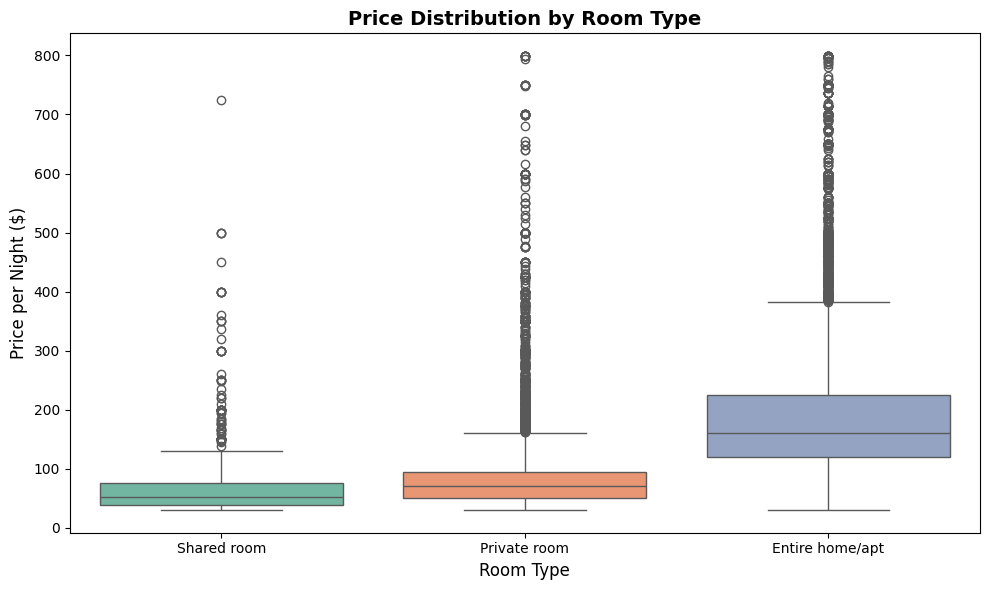

In [13]:
# Visualization 3: Price Distribution by Room Type
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean, x='room_type', y='price', palette='Set2',
            order=['Shared room', 'Private room', 'Entire home/apt'])
plt.title('Price Distribution by Room Type', fontsize=14, fontweight='bold')
plt.xlabel('Room Type', fontsize=12)
plt.ylabel('Price per Night ($)', fontsize=12)
plt.tight_layout()
plt.show()

## Summary and Interpretation

### Key Findings

This exploratory data analysis of the Airbnb NYC 2019 dataset revealed several meaningful patterns about the short-term rental market in New York City. The dataset contained 48,895 listings across five boroughs, and after removing price outliers using the 1st and 99th percentile thresholds, approximately 47,900 listings remained for analysis.

**Location significantly impacts pricing.** Manhattan commands the highest average rental prices among all NYC boroughs, followed by Brooklyn. This finding aligns with expectations given Manhattan's status as a major tourist destination and business center. The Bronx and Staten Island showed considerably lower average prices, reflecting their relative distance from typical tourist areas.

**Room type is the strongest categorical predictor of price.** Entire home and apartment listings are priced substantially higher than private rooms, which in turn cost more than shared rooms. This hierarchy reflects the value guests place on privacy and exclusive access to accommodations.

**The price distribution is right-skewed.** Most listings cluster at lower price points, with a long tail extending toward higher prices. The median price provides a more representative measure of typical listing cost than the mean due to this skewness.

### Interesting Patterns

The correlation analysis revealed that numeric features in this dataset have relatively weak linear relationships with price. This suggests that categorical factors such as location and room type, along with qualitative features not captured in the numeric data, play more significant roles in determining price than variables like minimum nights or number of reviews.

### Limitations and Assumptions

Several limitations should be considered when interpreting these results. First, this analysis used the median imputation strategy for missing numeric values, which assumes that missing data occurs at random. Second, the outlier removal process using percentile thresholds, while effective at eliminating extreme values, may have removed legitimate high-end luxury listings. Third, this dataset represents a single snapshot from 2019 and may not reflect current market conditions. Finally, the analysis focused on listed prices rather than actual transaction prices, which may differ due to seasonal adjustments, discounts, or negotiation.

### Surprising Observations

One unexpected finding was the relatively weak correlation between the number of reviews and price. Intuitively, one might expect that more frequently reviewed properties would command premium prices due to established reputation, but the data did not strongly support this assumption. This may indicate that review volume reflects booking frequency rather than quality or desirability.